In [2]:
import os
from torchvision import datasets
import torchvision
import torch
from torchvision.transforms import transforms
import torchvision.models as models
import numpy as np
from PIL import ImageFile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.ion()

In [3]:
batch_size = 64
num_workers = 0

train_transform = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
train_set = './Dataset/FIRE-SMOKE-DATASET/Train/'
valid_set = './Dataset/FIRE-SMOKE-DATASET/Test/'


train_data = datasets.ImageFolder(train_set, transform=train_transform)
valid_data = datasets.ImageFolder(valid_set, transform=valid_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

loaders = {
    'train': train_loader,
    'valid': valid_loader
}

In [5]:
class_names = ['Fire', 'Neutral', 'Smoke']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

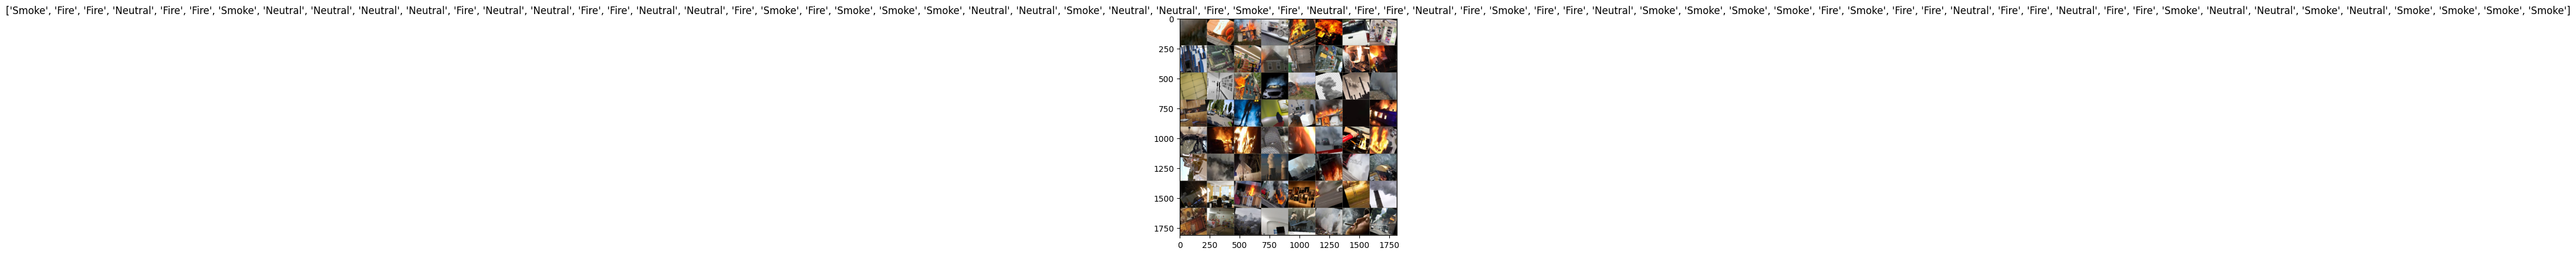

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
model = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
use_cuda = torch.cuda.is_available()

if use_cuda:
    model = model.cuda()
    
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Sequential(torch.nn.Linear(2048,128),
                                      torch.nn.ReLU(),
                                       torch.nn.Linear(128,3),
                                       torch.nn.Softmax(dim=1)
                                      )

for param in model.fc.parameters():
    param.requires_grad = True
    
if use_cuda:
    model_transfer = model.cuda()
    
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0005)

In [10]:
n_epochs = 5

train_accuracy_list = []
train_loss_list = []
valid_accuracy_list = []
valid_loss_list = []

def train(n_epochs, loader, model, optimizer, criterion, use_cuda):
    best_acc = 0.0
    valid_loss_min = float('inf')
       
    for epoch in range(1, (n_epochs+1)):
        
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0
        
        
        model.train()
        
        for batch_idx, (data, target) in enumerate(loaders['train']):
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            _, preds = torch.max(output, 1)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_acc = train_acc + torch.sum(preds == target.data)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            model.eval()
            correct = 0
        for batch_idx, (data, target) in enumerate(loaders['valid']):

            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            _, preds = torch.max(output, 1)
            loss = criterion(output, target)
            
            valid_acc = valid_acc + torch.sum(preds == target.data)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        train_acc = train_acc/len(loaders['train'].dataset)
        valid_acc = valid_acc/len(loaders['valid'].dataset)
        epoch_acc = valid_acc
        
        train_accuracy_list.append(train_acc)
        train_loss_list.append(train_loss)
        valid_accuracy_list.append(valid_acc)
        valid_loss_list.append(valid_loss)
        print(f"Validation Accuracy: {epoch_acc:.4f}")
        print('Epoch: {} \tTraining Acc: {:6f} \tTraining Loss: {:6f} \tValidation Acc: {:6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_acc,
            train_loss,
            valid_acc,
            valid_loss
            ))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            
            
            torch.save(model.state_dict(), './trained-models/best_model1.pt')
            print("New best model saved!")  
            
    return model,train_loss_list

In [11]:
model = train(n_epochs, loaders, model, optimizer, criterion, use_cuda)

Validation Accuracy: 0.8833
Epoch: 1 	Training Acc: 0.813333 	Training Loss: 0.000292 	Validation Acc: 0.883333 	Validation Loss: 0.002252
New best model saved!
Validation Accuracy: 0.9300
Epoch: 2 	Training Acc: 0.885556 	Training Loss: 0.000251 	Validation Acc: 0.930000 	Validation Loss: 0.002145
New best model saved!
Validation Accuracy: 0.9300
Epoch: 3 	Training Acc: 0.905185 	Training Loss: 0.000243 	Validation Acc: 0.930000 	Validation Loss: 0.002115
Validation Accuracy: 0.9267
Epoch: 4 	Training Acc: 0.909259 	Training Loss: 0.000242 	Validation Acc: 0.926667 	Validation Loss: 0.002105
Validation Accuracy: 0.9300
Epoch: 5 	Training Acc: 0.909630 	Training Loss: 0.000241 	Validation Acc: 0.930000 	Validation Loss: 0.002148


In [12]:
import torch
print(f"Is CUDA available? {torch.cuda.is_available()}")

Is CUDA available? True


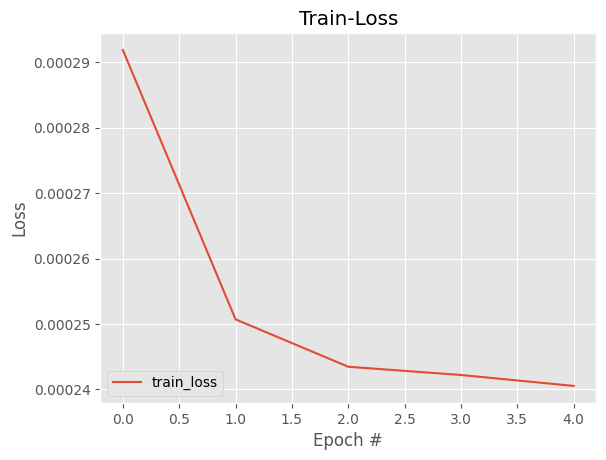

In [13]:
plt.style.use("ggplot")
plt.figure()
plt.plot([loss.item() for loss in train_loss_list], label="train_loss")
plt.title("Train-Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

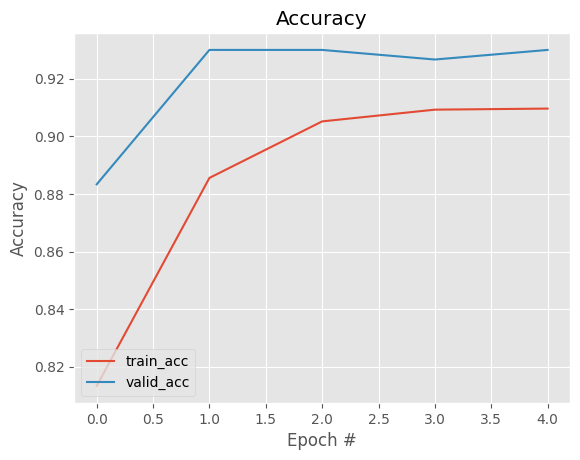

In [14]:

plt.style.use("ggplot")
plt.figure()

plt.plot([acc.item() for acc in train_accuracy_list], label="train_acc")
plt.plot([acc.item() for acc in valid_accuracy_list], label="valid_acc")

plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

In [15]:
torch.save(model, './trained-models/model_final.pth')

In [16]:
from PIL import Image

class_names = class_names = ['Fire', 'Neutral', 'Smoke']

def predict(image):
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    image = image.cuda()

    pred = model(image)
    idx = torch.argmax(pred)
    prob = pred[0][idx].item()*100
    
    return class_names[idx], prob

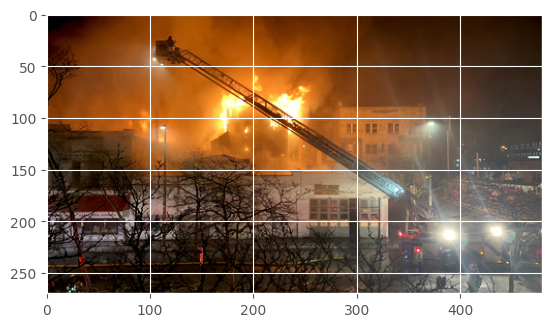

TypeError: 'tuple' object is not callable

In [17]:
def predict_and_show(path):
    img = Image.open(path)
    plt.imshow(img)
    plt.show()

    prediction, prob = predict(img)
    print(prediction, prob)
    

for img_file in os.listdir('./test-imgs/'):
    img_path = os.path.join('./test-imgs/', img_file)
    predict_and_show(img_path)